# Import our dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib as mpl
import sklearn as skl
import tensorflow as tf
import numpy as np
import hvplot.pandas
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from path import Path
# Import config file located outside current folder
import sys
sys.path.append("..")
from config import db_user, db_password, db_name, endpoint
from sqlalchemy import create_engine

# Load the San Francisco Crime Tables and store it as a DataFrame

In [2]:
# Connection
db_string = f"postgres://{db_user}:{db_password}@{endpoint}:5432/{db_name}"
engine = create_engine(db_string)

# Load tables
crime_data = pd.read_sql_table(table_name="sf_crime",con=engine)
geo_data = pd.read_sql_table(table_name="geographic",con=engine)
dates_data = pd.read_sql_table(table_name="crime_dates",con=engine)


In [3]:
# Join tables to generate a combined dataframe
sf_crime_df=crime_data.merge(dates_data, on="PdId", how='inner')
sf_crime_df=sf_crime_df.merge(geo_data, on="PdId", how='inner')

#Reorder columns
columnOrder = ["IncidntNum","Category","Descript","DayOfWeek","Date","Time","PdDistrict","Resolution","Address","X","Y","Location","PdId","ZipCode"]
sf_crime_df=sf_crime_df[columnOrder]
sf_crime_df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,ZipCode
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,2016-01-29,11:00:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120,94103
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,2016-01-29,11:00:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168,94103
2,141059263,WARRANTS,WARRANT ARREST,Monday,2016-04-25,14:59:00,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010,94124
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,2016-01-05,23:50:00,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000,94108
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,2016-01-01,00:30:00,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000,94102


# Prepare the Data

In [4]:
# Columns
sf_crime_df.columns

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId',
       'ZipCode'],
      dtype='object')

In [5]:
# Obtain the shape/dimensions of the dataframe.
sf_crime_df.shape

(150500, 14)

In [6]:
# Get data types of each column.
sf_crime_df.dtypes

IncidntNum             int64
Category              object
Descript              object
DayOfWeek             object
Date          datetime64[ns]
Time                  object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
Location              object
PdId                   int64
ZipCode                int64
dtype: object

In [7]:
# Count the number of unique values per column.
sf_crime_df.nunique()

IncidntNum    116699
Category          39
Descript         726
DayOfWeek          7
Date             366
Time            1439
PdDistrict        10
Resolution        14
Address        16130
X              19386
Y              19386
Location       19386
PdId          150500
ZipCode           25
dtype: int64

In [8]:
# Check for null values.
for column in sf_crime_df.columns:
    print(f"Column {column}  has {sf_crime_df[column].isnull().sum()} null values")

Column IncidntNum  has 0 null values
Column Category  has 0 null values
Column Descript  has 0 null values
Column DayOfWeek  has 0 null values
Column Date  has 0 null values
Column Time  has 0 null values
Column PdDistrict  has 1 null values
Column Resolution  has 0 null values
Column Address  has 0 null values
Column X  has 0 null values
Column Y  has 0 null values
Column Location  has 0 null values
Column PdId  has 0 null values
Column ZipCode  has 0 null values


In [9]:
# Drop the null/missing value.
sf_crime_df = sf_crime_df.dropna()

In [10]:
# Describe the data
sf_crime_df.describe()

,IncidntNum,X,Y,PdId,ZipCode
count,1.504990e+05,150499.000000,150499.000000,1.504990e+05,150499.000000
mean,1.616440e+08,-122.423599,37.768921,1.616440e+13,94113.222473
std,5.535983e+06,0.026210,0.023637,5.535983e+11,11.856508
min,1.135121e+07,-122.513642,37.707922,1.135121e+12,94102.000000
25%,1.603283e+08,-122.434036,37.756486,1.603283e+13,94103.000000
50%,1.606541e+08,-122.416903,37.775421,1.606541e+13,94110.000000
75%,1.609764e+08,-122.406605,37.785063,1.609764e+13,94118.000000
max,9.910090e+08,-122.365565,37.819975,9.910090e+13,94158.000000


## 1. Incident Number Column

In [11]:
# Review the IncidntNum duplicates in order to determine if they are necessary for our analysis.
incidnt_num_duplicates = sf_crime_df[sf_crime_df.IncidntNum.duplicated(keep='first')]
incidnt_num_duplicates.sort_values(by='IncidntNum', ascending=True).head(10)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,ZipCode
58324,16059760,OTHER OFFENSES,RESISTING ARREST,Monday,2016-07-25,00:28:00,SOUTHERN,"ARREST, BOOKED",100 Block of 10TH ST,-122.415077,37.774687,"(37.7746870888435, -122.415077154938)",1605976027170,94102
58323,16059760,OTHER OFFENSES,PROBATION VIOLATION,Monday,2016-07-25,00:28:00,SOUTHERN,"ARREST, BOOKED",100 Block of 10TH ST,-122.415077,37.774687,"(37.7746870888435, -122.415077154938)",1605976026170,94102
26092,100475254,WARRANTS,WARRANT ARREST,Friday,2016-08-26,08:00:00,NORTHERN,"ARREST, BOOKED",UNION ST / GOUGH ST,-122.427271,37.798134,"(37.7981336020854, -122.427270640646)",10047525463010,94109
26093,100475254,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Friday,2016-08-26,08:00:00,NORTHERN,"ARREST, BOOKED",UNION ST / GOUGH ST,-122.427271,37.798134,"(37.7981336020854, -122.427270640646)",10047525464020,94109
105442,110330052,ASSAULT,THREATS AGAINST LIFE,Thursday,2016-07-07,09:45:00,SOUTHERN,UNFOUNDED,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",11033005219057,94103
105445,120058272,WEAPON LAWS,CARRYING A CONCEALED WEAPON,Friday,2016-01-29,11:00:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212015,94103
105446,120058272,WEAPON LAWS,POSS OF FIREARM BY CONVICTED FELON/ADDICT/ALIEN,Friday,2016-01-29,11:00:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212080,94103
105447,120058272,WEAPON LAWS,"WEAPON, TAKING OR ATTEMPTING TO TAKE FROM PEAC...",Friday,2016-01-29,11:00:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827226213,94103
105448,120058272,OTHER OFFENSES,RESISTING ARREST,Friday,2016-01-29,11:00:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827227170,94103
105449,120058272,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Friday,2016-01-29,11:00:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827265010,94103


### Based on the dataframe, the duplicate incident numbers are created when there is more than one violation at the time of the report, therefore we will incldue all the incident numbers in our analysis as it includes different types of incident descriptions. 

## 2. Category Column

In [12]:
# Category_counts.
category_counts = sf_crime_df.Category.value_counts()
category_counts

LARCENY/THEFT                  40408
OTHER OFFENSES                 19599
NON-CRIMINAL                   17866
ASSAULT                        13577
VANDALISM                       8589
VEHICLE THEFT                   6419
WARRANTS                        5914
BURGLARY                        5802
SUSPICIOUS OCC                  5782
MISSING PERSON                  4338
DRUG/NARCOTIC                   4243
ROBBERY                         3299
FRAUD                           2635
SECONDARY CODES                 1841
TRESPASS                        1812
WEAPON LAWS                     1658
SEX OFFENSES, FORCIBLE           940
STOLEN PROPERTY                  882
RECOVERED VEHICLE                736
DISORDERLY CONDUCT               658
PROSTITUTION                     641
FORGERY/COUNTERFEITING           619
DRUNKENNESS                      465
DRIVING UNDER THE INFLUENCE      378
ARSON                            286
KIDNAPPING                       257
EMBEZZLEMENT                     168
L

In [13]:
# Bucket categories with less than 1000 counts into a new Category called "OTHER" as those categories represent a small amount of the total data. 
replace_category = list(category_counts[category_counts < 1000].index)

# Replace in DataFrame
for category in replace_category:
    sf_crime_df.Category = sf_crime_df.Category.replace(category,"OTHER")

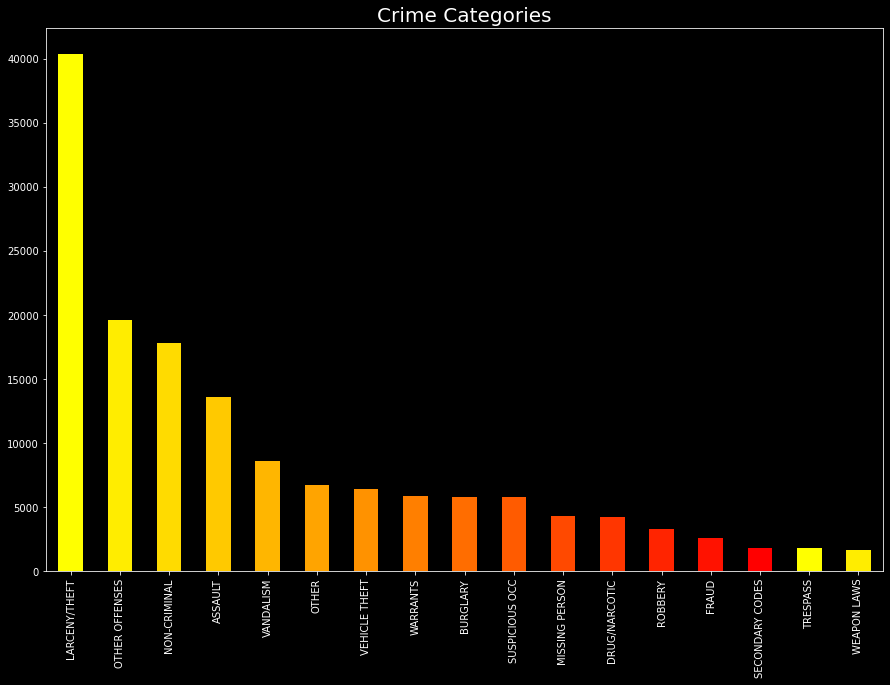

In [14]:
# Visualize the updated Category counts
category_counts = sf_crime_df.Category.value_counts()

plt.style.use('dark_background')

color = plt.cm.autumn_r(np.linspace(0, 1, 15))
category_counts.plot.bar(color= color, figsize = (15, 10))

plt.title('Crime Categories',fontsize = 20)

plt.xticks(rotation = 90)
plt.show()

## 3. Description Column

In [15]:
# Description counts.
descript_counts = sf_crime_df.Descript.value_counts()
descript_counts

GRAND THEFT FROM LOCKED AUTO                           17740
LOST PROPERTY                                           4596
AIDED CASE, MENTAL DISTURBED                            4566
PETTY THEFT OF PROPERTY                                 4416
MALICIOUS MISCHIEF, VANDALISM                           4262
                                                       ...  
WEAPON, ASSAULT, REGISTRATION OR TRANSFER VIOLATION        1
SAFE BURGLARY OF A WAREHOUSE                               1
VEHICLE ALARM CODE GRABBING DEVICE, POSSESS OR USE         1
CURFEW VIOLATION                                           1
ENCOURAGE MINOR TO USE BARBITUATES                         1
Name: Descript, Length: 726, dtype: int64

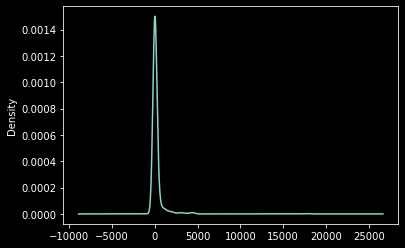

In [16]:
descript_counts.plot.density()

In [17]:
# Replace descriptions that have less than 1000 counts with "OTHER" as those descriptions represent a small amount of the total data.
replace_descript = list(descript_counts[descript_counts < 1000].index)

# Replace in DataFrame
for descript in replace_descript:
    sf_crime_df.Descript = sf_crime_df.Descript.replace(descript,"OTHER")

descript_counts = sf_crime_df.Descript.value_counts()
descript_counts

OTHER                                             47828
GRAND THEFT FROM LOCKED AUTO                      17740
LOST PROPERTY                                      4596
AIDED CASE, MENTAL DISTURBED                       4566
PETTY THEFT OF PROPERTY                            4416
MALICIOUS MISCHIEF, VANDALISM                      4262
BATTERY                                            4211
PETTY THEFT FROM LOCKED AUTO                       3994
STOLEN AUTOMOBILE                                  3603
DRIVERS LICENSE, SUSPENDED OR REVOKED              3376
WARRANT ARREST                                     3089
FOUND PROPERTY                                     3088
SUSPICIOUS OCCURRENCE                              2924
MALICIOUS MISCHIEF, VANDALISM OF VEHICLES          2866
INVESTIGATIVE DETENTION                            2506
TRAFFIC VIOLATION ARREST                           2233
GRAND THEFT OF PROPERTY                            2200
ENROUTE TO OUTSIDE JURISDICTION                 

## 4. Day of Week Column

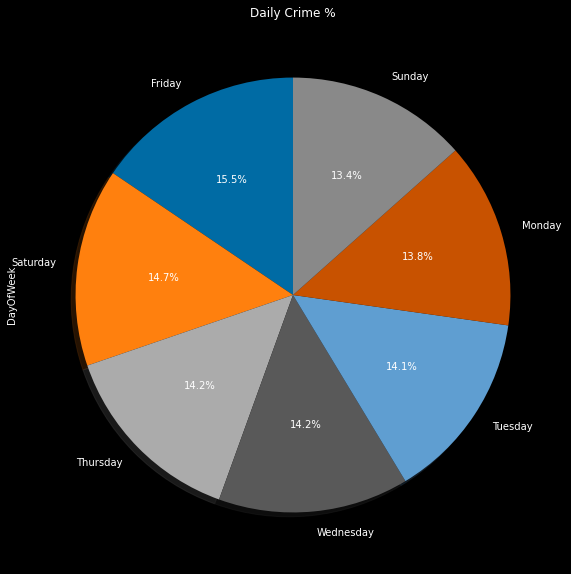

In [18]:
# Visualize daily crime counts. 
daily_counts = sf_crime_df.DayOfWeek.value_counts()

plt.style.use('tableau-colorblind10')

daily_counts.plot.pie(figsize= (15,10), autopct='%1.1f%%', shadow=True, startangle=90)

plt.title('Daily Crime %')

plt.show()

### The Daily Crime pie chart indicates Friday has the highest percentage at 15.5% but the distribution is almost identical for all days. 

## 5. Date Column

In [19]:
# Replace the 'Date' column with a 'Month' column in order to analyze incidents per month. 
sf_crime_df['Date'] = pd.to_datetime(sf_crime_df['Date'])

sf_crime_df['Month'] = sf_crime_df['Date'].dt.strftime('%b')
sf_crime_df = sf_crime_df.drop("Date", axis=1)

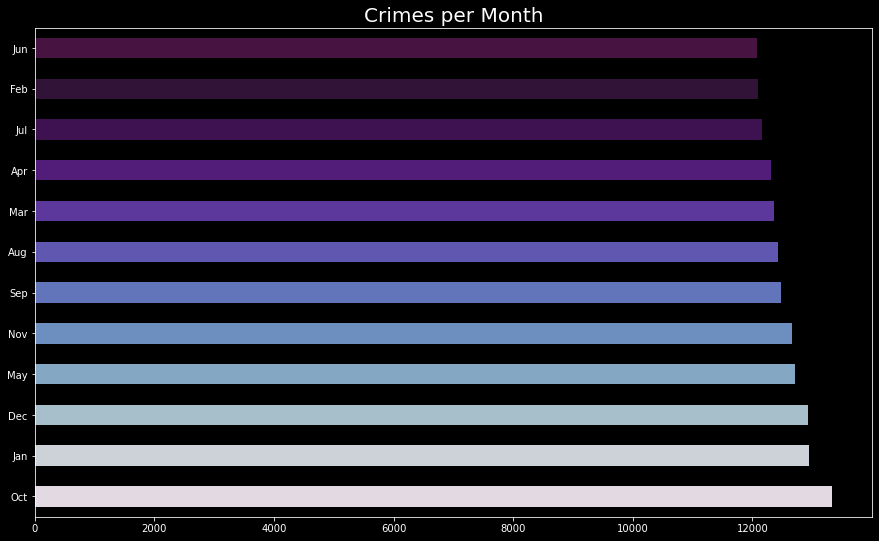

In [20]:
# Plot the monthly incidents.
monthly_counts = sf_crime_df.Month.value_counts()

color = plt.cm.twilight(np.linspace(0, 5, 100))

monthly_counts.plot.barh(color = color, figsize = (15, 9))

plt.title('Crimes per Month', fontsize = 20)
plt.show()

## 6. Time Column

In [21]:
# Replace the 'Time' column with an 'Hour' column in order to bin the data by night, morning, afternoon, evening.
# sf_crime_df['Time'] = pd.to_datetime(sf_crime_df['Time'])

sf_crime_df['Time_Hour'] = pd.to_datetime(sf_crime_df['Time'], format='%H:%M:%S').dt.hour

sf_crime_df = sf_crime_df.drop("Time", axis=1)

In [22]:
# Create a time _series
time_ser = pd.Series(sf_crime_df['Time_Hour']).astype(int)

In [23]:
# Establish the hour bins and group names.
hour_bins = [0, 6, 12, 18, 23]
group_names = ["Night", "Morning", "Afternoon", "Evening"]

In [24]:
# Cut time_series into the hour bins.
pd.cut(time_ser, hour_bins)

0          (6.0, 12.0]
1          (6.0, 12.0]
2         (12.0, 18.0]
3         (18.0, 23.0]
4                  NaN
              ...     
150495    (18.0, 23.0]
150496     (6.0, 12.0]
150497    (18.0, 23.0]
150498     (6.0, 12.0]
150499    (12.0, 18.0]
Name: Time_Hour, Length: 150499, dtype: category
Categories (4, interval[int64]): [(0, 6] < (6, 12] < (12, 18] < (18, 23]]

In [25]:
# Group the time_series on the hour ranges
time_ser.groupby(pd.cut(time_ser, hour_bins)).count()

Time_Hour
(0, 6]      16553
(6, 12]     37624
(12, 18]    51151
(18, 23]    38230
Name: Time_Hour, dtype: int64

In [26]:
# Add a new column to sf_crime_df to represent the hour_bins data and drop the 'Time_Hour' column.
sf_crime_df["Time_of_Day"] = pd.cut(time_ser, hour_bins, labels=group_names, include_lowest=True)
sf_crime_df = sf_crime_df.drop("Time_Hour", axis=1)
sf_crime_df.head()

,IncidntNum,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Location,PdId,ZipCode,Month,Time_of_Day
0,120058272,WEAPON LAWS,OTHER,Friday,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120,94103,Jan,Morning
1,120058272,WEAPON LAWS,OTHER,Friday,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168,94103,Jan,Morning
2,141059263,WARRANTS,WARRANT ARREST,Monday,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010,94124,Apr,Afternoon
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000,94108,Jan,Evening
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000,94102,Jan,Night


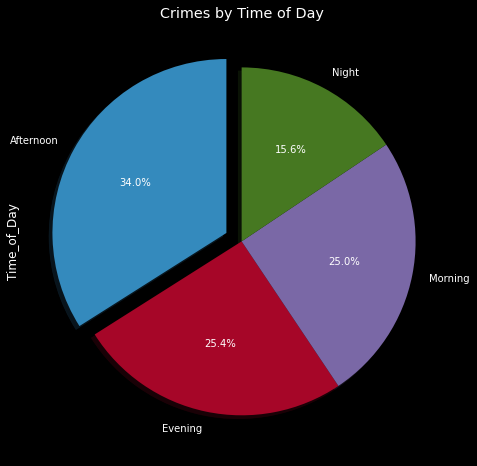

In [27]:
# Plot the data.
time_of_day_counts = sf_crime_df.Time_of_Day.value_counts()

plt.style.use('bmh')

time_of_day_counts.plot.pie(figsize= (15,8), autopct='%1.1f%%', shadow=True, startangle=90, explode = (0.1, 0.0, 0.0, 0.00))

plt.title('Crimes by Time of Day')

plt.show()

## 7. PdDistrict Column

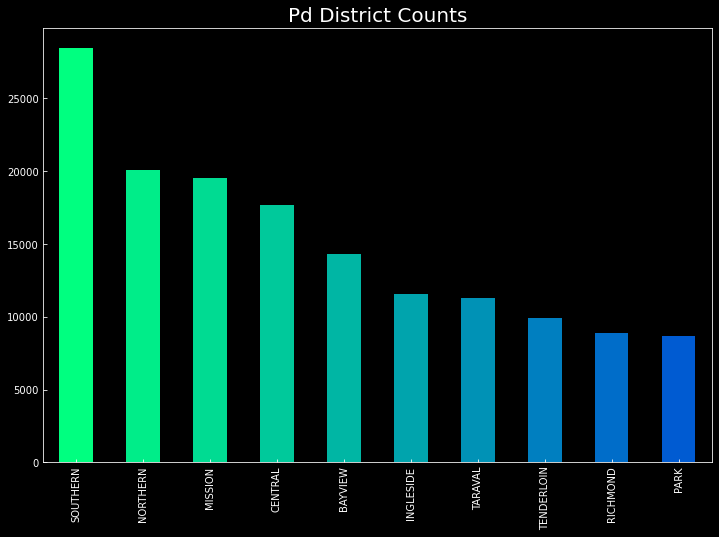

In [28]:
# Visualization of District conts.
district_counts = sf_crime_df.PdDistrict.value_counts()

plt.style.use('dark_background')

color = plt.cm.winter_r(np.linspace(0, 1, 15))
district_counts.plot.bar(color= color, figsize = (12, 8), grid=False)

plt.title('Pd District Counts',fontsize = 20)

plt.xticks(rotation = 90)
plt.show()

## 8. Resolution

In [29]:
# Resolution counts
resolution_counts = sf_crime_df['Resolution'].value_counts()
resolution_counts

NONE                                      107779
ARREST, BOOKED                             39416
UNFOUNDED                                   1608
JUVENILE BOOKED                             1056
EXCEPTIONAL CLEARANCE                        371
ARREST, CITED                                144
CLEARED-CONTACT JUVENILE FOR MORE INFO        58
NOT PROSECUTED                                22
LOCATED                                       20
PSYCHOPATHIC CASE                             17
JUVENILE CITED                                 3
JUVENILE DIVERTED                              2
COMPLAINANT REFUSES TO PROSECUTE               2
PROSECUTED BY OUTSIDE AGENCY                   1
Name: Resolution, dtype: int64

In [30]:
# Replace all resultions, except None and Arrest/Booked with "OTHER" in order to dertermine what % they represent. 
replace_resolution = list(resolution_counts[resolution_counts < 39146].index)

# Replace in DataFrame
for resolution in replace_resolution:
    sf_crime_df.Resolution = sf_crime_df.Resolution.replace(resolution,"OTHER")

resolution_counts = sf_crime_df.Resolution.value_counts()
resolution_counts


NONE              107779
ARREST, BOOKED     39416
OTHER               3304
Name: Resolution, dtype: int64

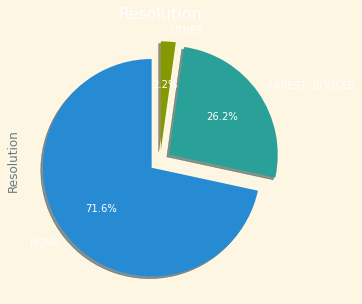

In [31]:
# Plot Resolutions

plt.style.use('Solarize_Light2')

resolution_counts.plot.pie(figsize= (10,5), autopct='%1.1f%%', shadow=True, startangle=90, explode=(0.1, 0.1, 0.1))

plt.title('Resolution')

plt.show()

## 9. Address Column

In [32]:
# Review the duplicate 'Address' values in order to determine if they are necessary for our analysis.
address_duplicates = sf_crime_df[sf_crime_df.Address.duplicated(keep='first')]
address_duplicates.sort_values(by='Address', ascending=True).head(20)

,IncidntNum,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Location,PdId,ZipCode,Month,Time_of_Day
69107,160693349,NON-CRIMINAL,OTHER,Saturday,SOUTHERN,"ARREST, BOOKED",0 Block of 10TH ST,-122.416759,37.775873,"(37.7758725985126, -122.416758741633)",16069334907053,94102,Aug,Night
73942,160734169,FRAUD,"CREDIT CARD, THEFT BY USE OF",Friday,SOUTHERN,NONE,0 Block of 10TH ST,-122.417160,37.776347,"(37.7763471604576, -122.417159710491)",16073416909320,94102,Sep,Afternoon
69109,160693349,OTHER OFFENSES,TRAFFIC VIOLATION,Saturday,SOUTHERN,"ARREST, BOOKED",0 Block of 10TH ST,-122.416759,37.775873,"(37.7758725985126, -122.416758741633)",16069334965015,94102,Aug,Night
145404,160528285,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Wednesday,SOUTHERN,NONE,0 Block of 10TH ST,-122.417258,37.776270,"(37.7762695066166, -122.41725760507)",16052828564070,94102,Jun,Afternoon
131335,166246796,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Saturday,SOUTHERN,NONE,0 Block of 10TH ST,-122.417258,37.776270,"(37.7762695066166, -122.41725760507)",16624679606374,94102,Feb,Afternoon
12907,160173824,ASSAULT,BATTERY,Wednesday,SOUTHERN,NONE,0 Block of 10TH ST,-122.417258,37.776270,"(37.7762695066166, -122.41725760507)",16017382404134,94102,Feb,Afternoon
137191,170001083,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Thursday,SOUTHERN,NONE,0 Block of 10TH ST,-122.417258,37.776270,"(37.7762695066166, -122.41725760507)",17000108306301,94102,Dec,Morning
69108,160693349,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Saturday,SOUTHERN,"ARREST, BOOKED",0 Block of 10TH ST,-122.416759,37.775873,"(37.7758725985126, -122.416758741633)",16069334965010,94102,Aug,Night
24502,160479246,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Monday,SOUTHERN,NONE,0 Block of 10TH ST,-122.417258,37.776270,"(37.7762695066166, -122.41725760507)",16047924664020,94102,Jun,Night
117246,166074898,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Sunday,SOUTHERN,NONE,0 Block of 10TH ST,-122.417160,37.776347,"(37.7763471604576, -122.417159710491)",16607489806372,94102,Mar,Afternoon


In [33]:
address_duplicate_count = sf_crime_df['Address'].value_counts().sort_values(ascending=False)
address_duplicate_count

800 Block of BRYANT ST         3561
800 Block of MARKET ST         1405
1000 Block of POTRERO AV        644
900 Block of MARKET ST          547
0 Block of UNITEDNATIONS PZ     452
                               ... 
28TH AV / CABRILLO ST             1
AHERN WY / HARRIET ST             1
200 Block of MONTALVO AV          1
PORTOLA DR / SANLEANDRO WY        1
0 Block of CAMBRIDGE ST           1
Name: Address, Length: 16129, dtype: int64

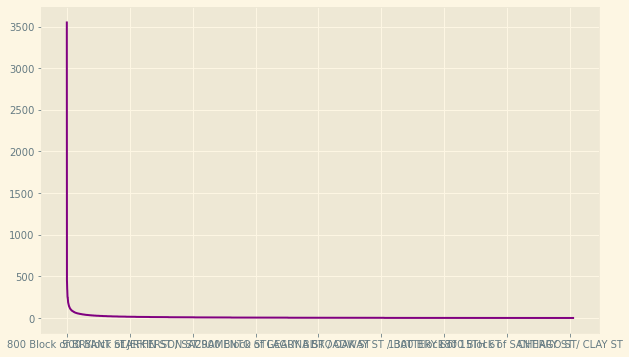

In [34]:
address_duplicate_count.plot.line(figsize=(10,6), color='purple')

### After looking at the duplicate address dataframe, it is unclear why there's several locations with over 500 incident reports. They might be central locations such as downtown or other high-traffic/public areas, therefore we will not drop anything from the 'Address' column until further analysis is performed.

## 10. X, Y, Location and ZipCode Columns

In [35]:
# Drop X, Y and Locatin columns as we keep the ZipCode column.
sf_crime_df = sf_crime_df.drop(['X', 'Y', 'Location'], axis=1)
sf_crime_df.head()

,IncidntNum,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,PdId,ZipCode,Month,Time_of_Day
0,120058272,WEAPON LAWS,OTHER,Friday,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,12005827212120,94103,Jan,Morning
1,120058272,WEAPON LAWS,OTHER,Friday,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,12005827212168,94103,Jan,Morning
2,141059263,WARRANTS,WARRANT ARREST,Monday,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,14105926363010,94124,Apr,Afternoon
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,TENDERLOIN,NONE,JONES ST / OFARRELL ST,16001366271000,94108,Jan,Evening
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,MISSION,NONE,16TH ST / MISSION ST,16000274071000,94102,Jan,Night


## 11. PDID Column

In [36]:
# Obtain the shape/dimensions of the dataframe in order to analyze the PdId column.
sf_crime_df.shape

(150499, 11)

In [37]:
# Count the number of unique items and look specifically at the PdId column.
sf_crime_df.nunique()

IncidntNum     116698
Category           17
Descript           40
DayOfWeek           7
PdDistrict         10
Resolution          3
Address         16129
PdId           150499
ZipCode            25
Month              12
Time_of_Day         4
dtype: int64

### After looking at the unique values in the sf_crime_df and comparing it to the lenght of the data, we can conclude that the Police Department Identification Number (PdId) is unique and no further analysis is required at this time. 

In [38]:
# Review the changes. 
sf_crime_df.head()

,IncidntNum,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,PdId,ZipCode,Month,Time_of_Day
0,120058272,WEAPON LAWS,OTHER,Friday,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,12005827212120,94103,Jan,Morning
1,120058272,WEAPON LAWS,OTHER,Friday,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,12005827212168,94103,Jan,Morning
2,141059263,WARRANTS,WARRANT ARREST,Monday,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,14105926363010,94124,Apr,Afternoon
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,TENDERLOIN,NONE,JONES ST / OFARRELL ST,16001366271000,94108,Jan,Evening
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,MISSION,NONE,16TH ST / MISSION ST,16000274071000,94102,Jan,Night


In [39]:
# Update the order of the columns.
sf_crime_df = sf_crime_df[['PdId', 'IncidntNum', 'Category', 'Descript', 'PdDistrict', 'Month', 'DayOfWeek', 'Time_of_Day', 'Address', 'ZipCode','Resolution']]

sf_crime_df.head()

,PdId,IncidntNum,Category,Descript,PdDistrict,Month,DayOfWeek,Time_of_Day,Address,ZipCode,Resolution
0,12005827212120,120058272,WEAPON LAWS,OTHER,SOUTHERN,Jan,Friday,Morning,800 Block of BRYANT ST,94103,"ARREST, BOOKED"
1,12005827212168,120058272,WEAPON LAWS,OTHER,SOUTHERN,Jan,Friday,Morning,800 Block of BRYANT ST,94103,"ARREST, BOOKED"
2,14105926363010,141059263,WARRANTS,WARRANT ARREST,BAYVIEW,Apr,Monday,Afternoon,KEITH ST / SHAFTER AV,94124,"ARREST, BOOKED"
3,16001366271000,160013662,NON-CRIMINAL,LOST PROPERTY,TENDERLOIN,Jan,Tuesday,Evening,JONES ST / OFARRELL ST,94108,NONE
4,16000274071000,160002740,NON-CRIMINAL,LOST PROPERTY,MISSION,Jan,Friday,Night,16TH ST / MISSION ST,94102,NONE


# Data Selection

## The process of finding and selecting the most useful features in a dataset and removing unnecessary features that will decreaese training speed and model performance. 

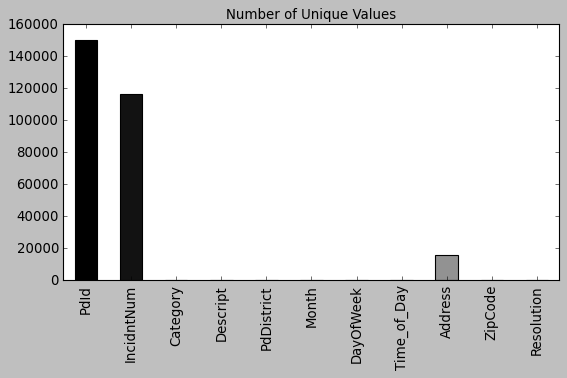

In [40]:
# Drop columns with single unique value features as they have zero variance.
sf_crime_df_nunique = sf_crime_df.nunique()

plt.style.use('classic')

color = plt.cm.gray(np.linspace(0, 1, 15))
sf_crime_df_nunique.plot.bar(color= color, figsize = (8, 4), grid=False)

plt.title('Number of Unique Values',fontsize = 12)

plt.show()

In [41]:
sf_crime_df = sf_crime_df.drop(['PdId', 'IncidntNum', 'Address'], axis=1)
sf_crime_df.head()

,Category,Descript,PdDistrict,Month,DayOfWeek,Time_of_Day,ZipCode,Resolution
0,WEAPON LAWS,OTHER,SOUTHERN,Jan,Friday,Morning,94103,"ARREST, BOOKED"
1,WEAPON LAWS,OTHER,SOUTHERN,Jan,Friday,Morning,94103,"ARREST, BOOKED"
2,WARRANTS,WARRANT ARREST,BAYVIEW,Apr,Monday,Afternoon,94124,"ARREST, BOOKED"
3,NON-CRIMINAL,LOST PROPERTY,TENDERLOIN,Jan,Tuesday,Evening,94108,NONE
4,NON-CRIMINAL,LOST PROPERTY,MISSION,Jan,Friday,Night,94102,NONE


### The rest of the data will be kept as it seems it can help our model.  

In [42]:
# Select and analyze the 'Resolution' column (this will be the label we will attempt to predict).
sf_crime_df['Resolution'].value_counts()

NONE              107779
ARREST, BOOKED     39416
OTHER               3304
Name: Resolution, dtype: int64

In [43]:
# Since we want to predict whether or not a person will be Arrested/Booked, we will drop the "OTHER" column in order to transform our column into a binary classifier during the Tranformation Process later on in our analysis. 

sf_crime_df = sf_crime_df[sf_crime_df.Resolution != "OTHER"]
sf_crime_df['Resolution'].value_counts()

# Also, during our Data Cleaning we created a pie chart indicating the "OTHER" column only represented 2.2% of the resolutions, therefore it should not impact our analysis by removing it.  

NONE              107779
ARREST, BOOKED     39416
Name: Resolution, dtype: int64

# Data Processing

In [44]:
# Convert all data to numerical data. 
sf_crime_df.dtypes

Category         object
Descript         object
PdDistrict       object
Month            object
DayOfWeek        object
Time_of_Day    category
ZipCode           int64
Resolution       object
dtype: object

In [45]:
sf_crime_df["Time_of_Day"] = sf_crime_df['Time_of_Day'].astype('object')
sf_crime_df.dtypes

Category       object
Descript       object
PdDistrict     object
Month          object
DayOfWeek      object
Time_of_Day    object
ZipCode         int64
Resolution     object
dtype: object

In [46]:
# Generate our categorical variable list
sf_crime_cat = sf_crime_df.dtypes[sf_crime_df.dtypes == "object"].index.tolist()

In [47]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(sf_crime_df[sf_crime_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(sf_crime_cat)
encode_df.head()

,Category_ASSAULT,Category_BURGLARY,Category_DRUG/NARCOTIC,Category_FRAUD,Category_LARCENY/THEFT,Category_MISSING PERSON,Category_NON-CRIMINAL,Category_OTHER,Category_OTHER OFFENSES,Category_ROBBERY,...,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,"Resolution_ARREST, BOOKED",Resolution_NONE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [48]:
# Merge one-hot encoded features and drop the originals
sf_crime_df = sf_crime_df.merge(encode_df,left_index=True, right_index=True)
sf_crime_df = sf_crime_df.drop(sf_crime_cat,1)
sf_crime_df.head()

,ZipCode,Category_ASSAULT,Category_BURGLARY,Category_DRUG/NARCOTIC,Category_FRAUD,Category_LARCENY/THEFT,Category_MISSING PERSON,Category_NON-CRIMINAL,Category_OTHER,Category_OTHER OFFENSES,...,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,"Resolution_ARREST, BOOKED",Resolution_NONE
0,94103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,94103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,94124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,94108,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,94102,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


# Data Transformation

In [49]:
# Saving cleaned data.